# <center> Лабораторная работа 1.  </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
### Необходимо предсказывать пол клиента, основываясь на его транзакционных исторических данных. 

###История транзакция находится на сайте [Kaggle](https://www.kaggle.com/c/python-and-analyze-data-final-project/data)

### Вы будете строить предиктивные модели и отправлять результаты своего моделирования на платформу [Kaggle](https://www.kaggle.com/t/e8a939488d274dab9051cce14d5ca952), где и будет оцениваться каждое решение и положение участников. 
### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_auc_score

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [35]:
from google.colab import files
from google.colab import drive

In [36]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим наборы данных

* transactions.csv - таблица содержит историю транзакций клиентов банка за один год и три месяца.
* gender_train.csv - таблица содержит информацию по полу для части клиентов, для которых он известен.
* tr_mcc_codes.csv - таблица содержит описание mcc-кодов транзакций.
* tr_types.csv - таблица содержит описание типов транзакций.
*gender_test_kaggle_sample_submission.csv - пример файла для загрузки решения.

In [37]:
dir = '/content/drive/My Drive/data/'
tr_mcc_codes = pd.read_csv(dir+'tr_mcc_codes.csv', sep=';',index_col='mcc_code')
tr_types = pd.read_csv(dir+'tr_types.csv', sep=';', index_col='tr_type')
gender_train = pd.read_csv(dir+'gender_train.csv',index_col='customer_id')
gender_test = pd.read_csv(dir+'gender_test_kaggle_sample_submission.csv',index_col='customer_id')
transactions = pd.read_csv(dir+'transactions.zip',index_col='customer_id')


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [38]:
transactions

,tr_datetime,mcc_code,tr_type,amount,term_id
customer_id,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN
39026145,1 10:19:29,6011,7010,56147.89,NaN
39026145,1 10:20:56,4829,2330,-56147.89,NaN
39026145,1 10:39:54,5499,1010,-1392.47,NaN
39026145,2 15:33:42,5499,1010,-920.83,NaN
...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113
61870738,454 10:54:60,5411,1010,-1652.77,022915
61870738,454 14:23:59,5499,1010,-4687.23,10217113


In [39]:
transactions.describe()

,mcc_code,tr_type,amount
count,6.849346e+06,6.849346e+06,6.849346e+06
mean,5.589776e+03,2.517356e+03,-2.054285e+04
std,6.035857e+02,2.270108e+03,4.777528e+05
min,7.420000e+02,1.000000e+03,-1.459845e+08
25%,5.200000e+03,1.030000e+03,-2.245916e+04
50%,5.641000e+03,1.110000e+03,-5.480030e+03
75%,6.010000e+03,2.370000e+03,-1.122960e+03
max,9.402000e+03,8.146000e+03,1.459845e+08


In [40]:
gender_train

,gender
customer_id,
10928546,1
69348468,1
61009479,0
74045822,0
27979606,1
...,...
90417572,0
66837341,0
10758984,1


In [41]:
transactions_train = transactions.join(gender_train, how='inner', on='customer_id')
transactions_test = transactions.join(gender_test, how='inner', on='customer_id')

In [42]:
transactions_train


,tr_datetime,mcc_code,tr_type,amount,term_id,gender
customer_id,,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN,1
39026145,1 10:19:29,6011,7010,56147.89,NaN,1
39026145,1 10:20:56,4829,2330,-56147.89,NaN,1
39026145,1 10:39:54,5499,1010,-1392.47,NaN,1
39026145,2 15:33:42,5499,1010,-920.83,NaN,1
...,...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113,0
61870738,454 10:54:60,5411,1010,-1652.77,022915,0
61870738,454 14:23:59,5499,1010,-4687.23,10217113,0


In [43]:
transactions_train.isna().sum()

tr_datetime          0
mcc_code             0
tr_type              0
amount               0
term_id        1519541
gender               0
dtype: int64

Так как суммы расходов могут быть очень большими, то выполним преобразование - прологарифмируем суммы расходов и доходов, сохраняя знак

In [44]:
transactions_train['log_amount'] = np.sign(transactions_train['amount'])*np.log10(np.abs(transactions_train['amount']))  
transactions_test['log_amount'] = np.sign(transactions_test['amount'])*np.log10(np.abs(transactions_test['amount'])) 


In [45]:
transactions_train

,tr_datetime,mcc_code,tr_type,amount,term_id,gender,log_amount
customer_id,,,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN,1,-3.351394
39026145,1 10:19:29,6011,7010,56147.89,NaN,1,4.749333
39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,-4.749333
39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,-3.143786
39026145,2 15:33:42,5499,1010,-920.83,NaN,1,-2.964179
...,...,...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113,0,-3.714065
61870738,454 10:54:60,5411,1010,-1652.77,022915,0,-3.218212
61870738,454 14:23:59,5499,1010,-4687.23,10217113,0,-3.670916


In [46]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(tr_mcc_codes)
#transactions_train = transactions_train.loc[transactions_train['mcc_code']==5977]

                                            mcc_description
mcc_code                                                   
742                                     Ветеринарные услуги
1711      Генеральные подрядчики по вентиляции, теплосна...
1731                            Подрядчики по электричеству
1799      Подрядчики, специализированная торговля — нигд...
2741               Разнообразные издательства/печатное дело
3000                                Авиалинии, авиакомпании
3351                        Агентства по аренде автомобилей
3501                         Жилье — отели, мотели, курорты
4111      Транспортировка — пригородные и локальные сезо...
4112                        Пассажирские железные перевозки
4121                                       Лимузины и такси
4131                                       Автобусные линии
4214      Агентства по автотранспортным перевозкам, мест...
4215      Услуги курьера — по воздуху и на земле, агентс...
4411                                    

In [47]:
tr_types

,tr_description
tr_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в дру...
...,...
2990,Списание по требованию
2992,Списание средств для погашения задолженности п...
3001,Комиссия за обслуживание ссудного счета


Сформируем базовые переменные по каждому клиенту. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:

* минимум
* максимум
* среднее
* медиана
* среднеквадратичное отклонение
* количество


In [48]:
def features_creation_basic(x): 
    base_feature = 'log_amount'
    features = []
    features.append(pd.Series(x[x[base_feature]>0][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x[base_feature]<0][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)



In [49]:
data_train = transactions_train.groupby(transactions_train.index).apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation_basic)


In [50]:
all_features = ['positive_transactions_min',
                'positive_transactions_max',
                'positive_transactions_mean',
                'positive_transactions_median',
                'positive_transactions_std',
                'positive_transactions_count',
                'negative_transactions_min',
                'negative_transactions_max',
                'negative_transactions_mean',
                'negative_transactions_median',
                'negative_transactions_std']

In [51]:
data_train

log_amount,positive_transactions_min,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_std,positive_transactions_count,negative_transactions_min,negative_transactions_max,negative_transactions_mean,negative_transactions_median,negative_transactions_std,negative_transactions_count
customer_id,,,,,,,,,,,,
22899,1.944680,5.942458,4.457634,4.527485,0.743689,68.0,-5.938824,-1.944680,-3.933557,-3.942458,0.746413,166.0
28753,3.895462,6.491273,5.708695,5.845334,0.565669,50.0,-6.511153,-3.351394,-4.616519,-4.424907,0.916209,244.0
42096,3.828515,5.828515,5.064168,5.050363,0.391880,66.0,-5.528641,-1.404492,-3.917520,-3.946867,0.587829,870.0
49793,3.050364,5.050363,4.040181,4.050364,0.592910,25.0,-5.828515,-2.196480,-3.682071,-3.572529,0.716546,488.0
50940,3.652423,3.652423,3.652423,3.652423,0.000000,12.0,-5.041590,-2.731605,-3.986787,-4.050364,0.485151,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99917144,3.351394,4.351394,3.950511,4.050364,0.360842,7.0,-5.722461,-0.994757,-3.401760,-3.339952,0.640782,663.0
99967537,NaN,NaN,NaN,NaN,NaN,0.0,-5.527485,-3.351394,-4.599798,-5.164307,0.954335,13.0
99984336,4.652424,5.905276,4.881654,4.828515,0.305477,18.0,-5.782757,-3.652423,-5.118301,-5.338165,0.586380,45.0


In [52]:
data_test

log_amount,positive_transactions_min,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_std,positive_transactions_count,negative_transactions_min,negative_transactions_max,negative_transactions_mean,negative_transactions_median,negative_transactions_std,negative_transactions_count
customer_id,,,,,,,,,,,,
6815,2.351390,6.392786,4.591282,4.700878,1.308400,6.0,-5.351393,-1.351410,-3.859060,-3.817520,0.604215,220.0
27914,3.050364,4.953453,3.735907,3.749334,0.476576,35.0,-5.665261,-3.050364,-3.725578,-3.351394,0.709207,76.0
31385,3.351394,5.300783,4.548796,4.618565,0.459513,23.0,-5.561538,-1.226342,-3.560241,-3.536779,0.607331,342.0
38084,4.050364,6.091756,5.176949,5.183483,0.429995,114.0,-6.057955,-0.673942,-4.026639,-3.953453,0.627298,838.0
78659,2.351390,5.497522,4.260941,4.351394,0.515682,46.0,-4.852339,-2.527488,-3.535411,-3.351394,0.341888,273.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99918216,4.050364,5.408298,5.085630,5.351393,0.581575,5.0,-5.366334,-2.726140,-3.844892,-3.862340,0.568767,183.0
99938948,3.351394,5.618565,4.484818,4.652424,0.522167,43.0,-5.630147,-1.652440,-3.754461,-3.828515,0.602875,591.0
99953525,4.351394,5.351393,5.040898,5.050363,0.203723,16.0,-5.749333,-2.527488,-4.327291,-4.303263,0.554365,156.0


Сформируем вектор целевой переменной

In [53]:
target = data_train.join(gender_train, how='inner')['gender']

Метрику ROC AUC будем вычислять с помощью стандартной функции

In [54]:
roc_auc_score(target, target)

1.0

In [55]:
data_train1 = data_train.join(gender_train, how='inner')

Проанализируем различные пары переменных

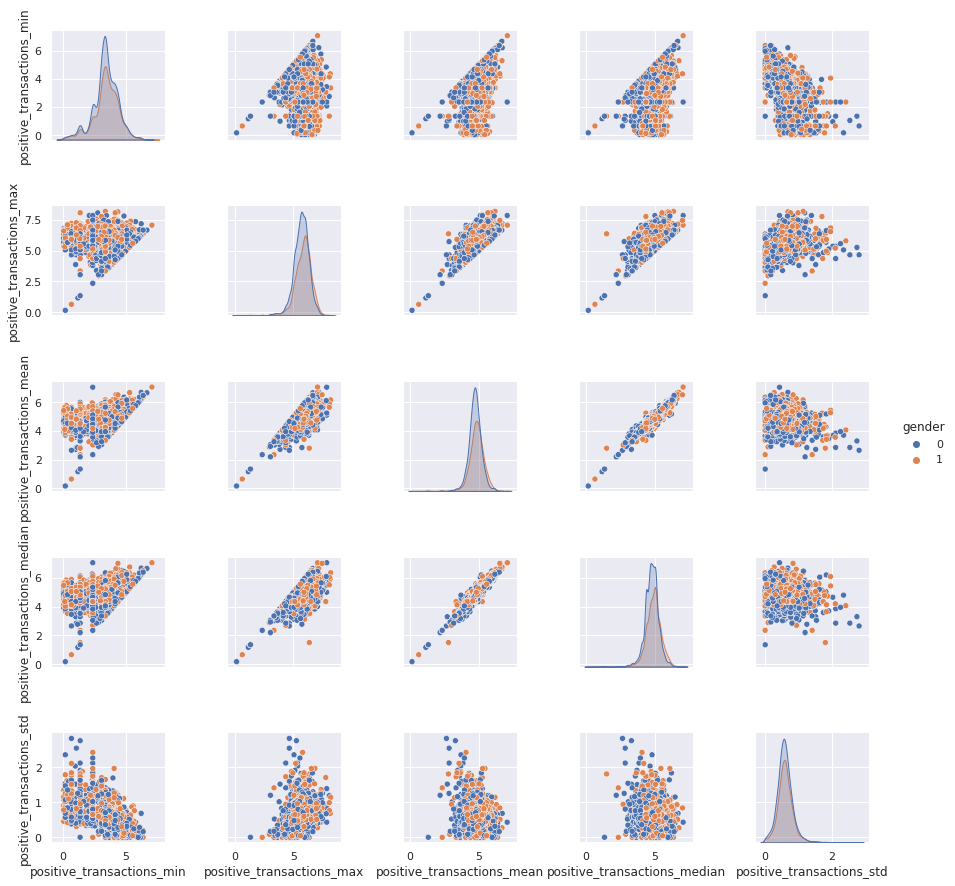

In [56]:
sns.set()
sns.pairplot(data_train1[['positive_transactions_min',	'positive_transactions_max',	'positive_transactions_mean',	'positive_transactions_median',	'positive_transactions_std','gender']],
hue="gender", diag_kind="kde")

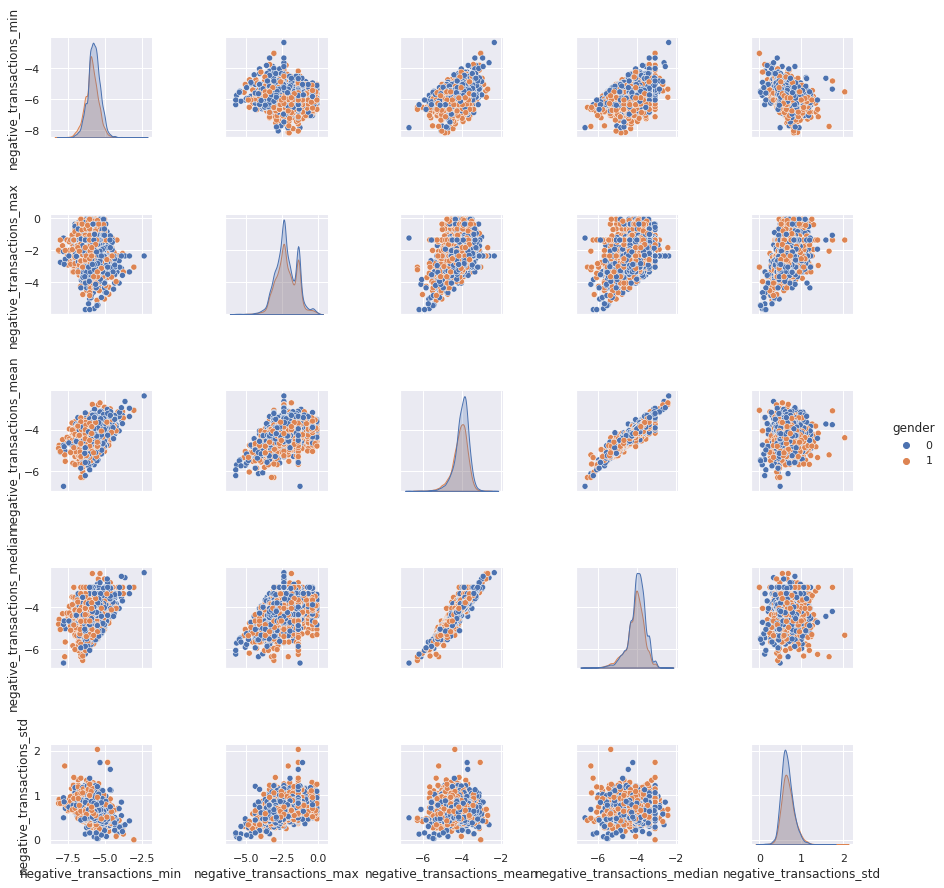

In [57]:
sns.pairplot(data_train1[['negative_transactions_min',	'negative_transactions_max',	'negative_transactions_mean',	'negative_transactions_median',	'negative_transactions_std','gender']],
hue="gender", diag_kind="kde")

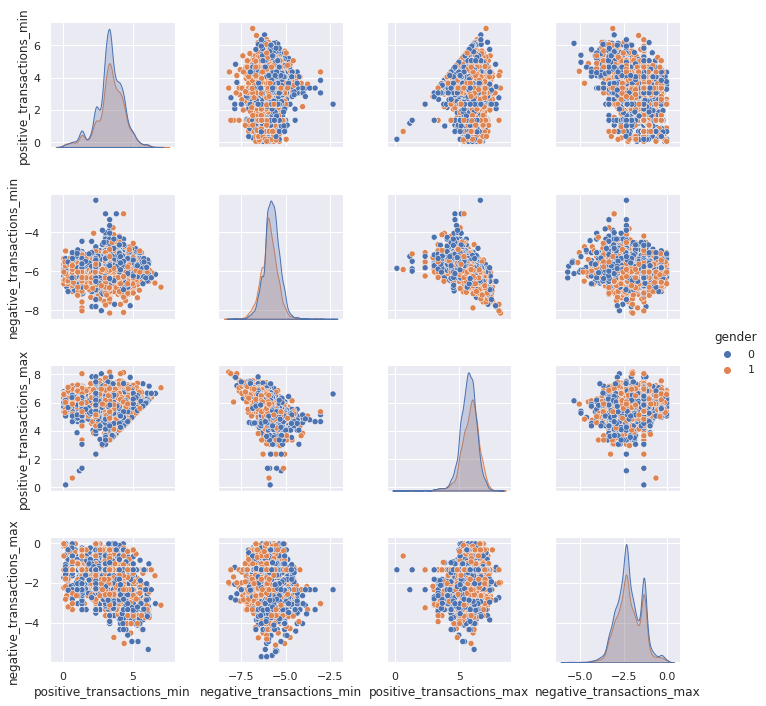

In [58]:
sns.pairplot(data_train1[['positive_transactions_min', 'negative_transactions_min',	'positive_transactions_max', 'negative_transactions_max','gender']],
hue="gender", diag_kind="kde")

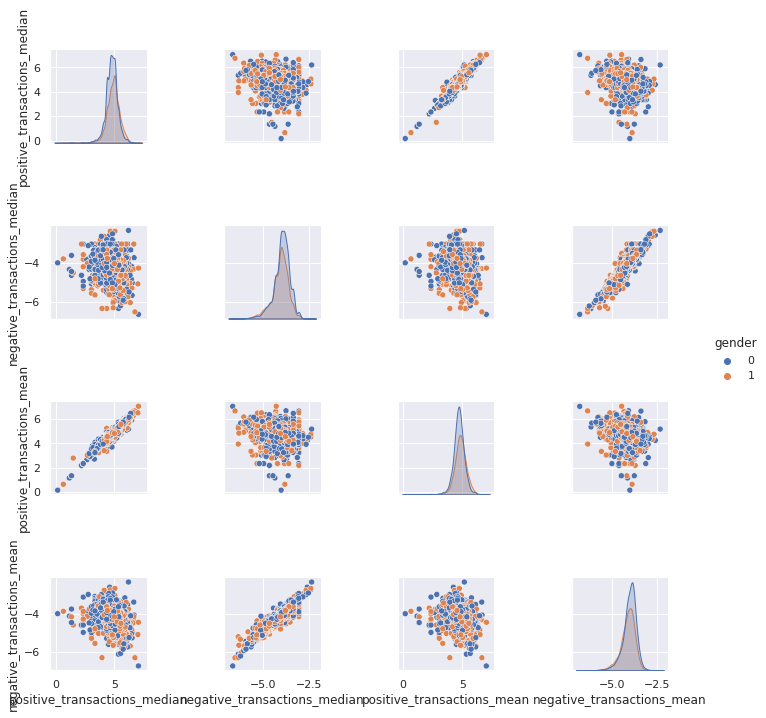

In [59]:
sns.pairplot(data_train1[['positive_transactions_median', 'negative_transactions_median',	'positive_transactions_mean', 'negative_transactions_mean','gender']],
hue="gender", diag_kind="kde")

Так как при агрегировании появились NAN их нужно заменить

In [60]:
X1 = data_train
X1.isna().sum()

log_amount
positive_transactions_min        678
positive_transactions_max        678
positive_transactions_mean       678
positive_transactions_median     678
positive_transactions_std       1046
positive_transactions_count        0
negative_transactions_min          8
negative_transactions_max          8
negative_transactions_mean         8
negative_transactions_median       8
negative_transactions_std         16
negative_transactions_count        0
dtype: int64

In [61]:
X = data_train.fillna(0)
X.isna().sum()


log_amount
positive_transactions_min       0
positive_transactions_max       0
positive_transactions_mean      0
positive_transactions_median    0
positive_transactions_std       0
positive_transactions_count     0
negative_transactions_min       0
negative_transactions_max       0
negative_transactions_mean      0
negative_transactions_median    0
negative_transactions_std       0
negative_transactions_count     0
dtype: int64

Применим для предсказания линейный дискриминант Фишера по всем переменным

In [62]:
y = target
clf = LinearDiscriminantAnalysis().fit(X, y)
# другие классификаторы
#clf = QuadraticDiscriminantAnalysis().fit(X, y)
#clf = svm.SVC(kernel='linear').fit(X, y)
#clf = svm.SVC(kernel='poly', degree=2).fit(X, y)
#clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
print(roc_auc_score(target, y_pred))

0.5721157666818693


Повторим на тестовой выборке

In [63]:
X = data_test[all_features].fillna(0)
X.isna().sum()

log_amount
positive_transactions_min       0
positive_transactions_max       0
positive_transactions_mean      0
positive_transactions_median    0
positive_transactions_std       0
positive_transactions_count     0
negative_transactions_min       0
negative_transactions_max       0
negative_transactions_mean      0
negative_transactions_median    0
negative_transactions_std       0
dtype: int64

In [64]:
y_pred = clf.predict(X)


ValueError: ignored

In [ ]:
submission = pd.DataFrame(index=data_test.index, data=y_pred, columns=['probability'])

In [ ]:
submission.describe()

Сохраним файл для отправки в Kaggle

In [ ]:
submission.to_csv('linear.csv')
files.download('linear.csv')